In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.metrics import classification_report

In [ ]:
# Load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f'X_train: {x_train.shape}')
print(f'Y_train: {y_train.shape}')
print(f'X_test:  {x_test.shape}')
print(f'Y_test:  {y_test.shape}')

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [ ]:
# concatenate the training and testing sets
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))

# index the dataset to select only images with labels 0 and 4
idx = np.where((y == 0) | (y == 4))[0]
x = x[idx]
y = y[idx]

# take a random sample of 2000 images for each label
idx_0 = np.random.choice(np.where(y == 0)[0], size=2000, replace=False)
idx_4 = np.random.choice(np.where(y == 4)[0], size=2000, replace=False)
x_sample = np.concatenate((x[idx_0], x[idx_4]))
y_sample = np.concatenate((y[idx_0], y[idx_4]))
y_sample[y_sample == 4] = 1
print(f'X_sample: {x_sample.shape}')
print(f'Y_sample: {y_sample.shape}')

x_sample: (4000, 28, 28)
y_sample: (4000,)


In [14]:
class KMeansClassifier:
    def __init__(self, x, k: int = 2, iterations: int = 20, seed: int = 3):
        """
        :param x: array
        Training data, must be in the format (n, dims).
        Images can be used when reshaped from (n, y, x, c) to (n, y*x*c)
        
        :param k: int
        Number of clusters to use for K-Means classifier, default is 2.
        
        :param iterations: int
        number of iterations, default is 20
        
        :param viz_it: bool
        indicate whether to visualize each iteration
        
        :param vis_fin: bool
        indicate whether to visualize the final clusters
        """
        # set the seed and assign initial variables
        np.random.seed(seed)
        self.k = k
        self.dims = x.shape[1]
        self.x = x
        self.iterations = iterations
        self.viz = (False, False)
        
        # get max value of each dimension
        self.dim_lims = np.array(x.max(axis=0))
        
        # create a k*dim array of random init centroid coords
        # get coords by multiplying array of dimension limits by array of random floats
        self.centroids = np.array([np.array(self.dim_lims * np.random.rand(self.dims)) for i in range(k)])
        print(f'{self.centroids.shape[0]} clusters initiated...')
        
    def train(self, viz_it: bool = False, viz_fin: bool = False, debug: bool = False):
        """
        :param viz_it: bool
        indicate whether to visualize each iteration, default is False
        :param viz_fin: bool
        indicate whether to visualize the final clusters, default is False
        :param debug: bool
        indicate whether to include debug prints, default is False
        """

        print('Initializing...')
        self.viz = (viz_it, viz_fin)
        # for c in range(self.centroids.shape[0]):
        #     print(f'Initial Centroid {c}: {self.centroids[c, :]}')
                
        if self.viz[0]:
            self.plot_clusters(self.x, None, step='Initial')
                
        for i in range(self.iterations):
            # print('-'*30)
            print(f'Iteration: {i}')
            if debug:
                for c in range(self.centroids.shape[0]):
                  print(f'Centroid {c}: {self.centroids[c, :]}')

            # get the closest cluster for each data point
            assignments = get_clusters(self.centroids, self.x)
            
            # if all clusters contain at least 1 point, get all new clusters
            if all([any(assignments == j) for j in range(self.k)]):
                # get the coordinates of the new centroids by averaging the points in their clusters
                self.centroids = np.array([self.x[assignments == j, :].mean(axis = 0) for j in range(self.k)])
                
            # if any clusters are empty, only update centroids containing points
            else:
                for j in range(self.k):
                    if any(assignments == j):
                        self.centroids[j, :] = x[assignments == j, :].mean(axis = 0)
            
            if self.viz[0]:
                self.plot_clusters(self.x, assignments, step=f'Iteration {i}')

        # get the cluster assignments for each element in x
        assignments = get_clusters(self.centroids, self.x)
        
        if self.viz[1]:
            self.plot_clusters(self.x, assignments, step='Final')
        
        return assignments
        
    def plot_clusters(self, x, assignments, step: str):
        # Create a color map for the clusters
        colors = plt.cm.get_cmap('viridis', self.k)

        # Plot the data points in different colors based on their cluster assignments
        if assignments is not None:
            for j in range(self.k):
                cluster_points = x[assignments == j, :]
                plt.scatter(cluster_points[:, 0], 
                            cluster_points[:, 1], 
                            color=colors(j), 
                            label=f'Cluster {j}')
        else:
            plt.scatter(x[:, 0], 
                        x[:, 1], 
                        color=colors(0), 
                        label='Initial Data')

        # Plot the centroids in a separate color
        plt.scatter(self.centroids[:, 0], 
                    self.centroids[:, 1], 
                    color='red', 
                    marker='x', 
                    s=100, 
                    label='Centroids')

        plt.legend()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'{step} Clusters')
        plt.show()
        
        
def get_clusters(centroid_arr, arr, debug: bool = False):
    """
    :params: centroid_arr: array
    contains cluster centroids, format is (k, dims)
    :params: arr: array
    containing training data, format is (n, dims)
    :params: debug: bool
    indicate whether to include debug prints, default is False
    
    calculates the euclidian distance between all vectors in
    training set and centroids
    """
    
    # convert centroid_arr and arr into the necessary shapes for
    # array operations
    centroid_arr = centroid_arr[np.newaxis, ...]    
    arr = arr[:, np.newaxis, :]
    
    # calculate the euclidean distance between each point and 
    dist = np.sqrt((arr - centroid_arr)**2).sum(axis=-1)
    
    # get the index with the minimum distance for each point
    assignments = np.argmin(dist, axis=1)
    if debug:
        print(f'{centroid_arr.shape = }')
        print(f'{arr.shape = }')
        print(f'{dist.shape = }')
        print(f'{assignments.shape = }')

    return assignments

## MNIST Test

In [ ]:
kmeans = KMeansClassifier(x_sample.reshape(4000, 784), 2, iterations=2, seed=3)
preds = kmeans.train(viz_it=False, viz_fin=False)
print(classification_report(y_sample, preds))

2 clusters initiated...
Initialization...
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      2000
           1       0.87      1.00      0.93      2000

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



## Test 1

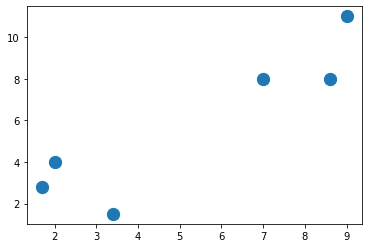

In [15]:
x = np.array([[2, 4],
              [1.7, 2.8],
              [7, 8],
              [8.6, 8],
              [3.4, 1.5],
              [9, 11]])

plt.scatter(x[:,0], x[:,1], s=150)
plt.show()

2 clusters initiated...
Initializing...


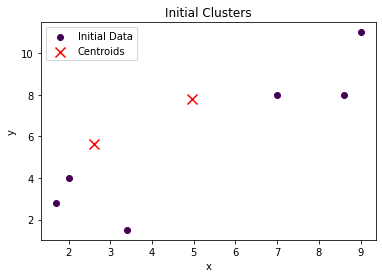

Iteration: 0


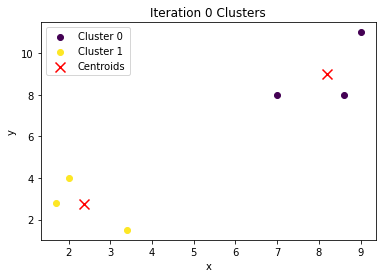

Iteration: 1


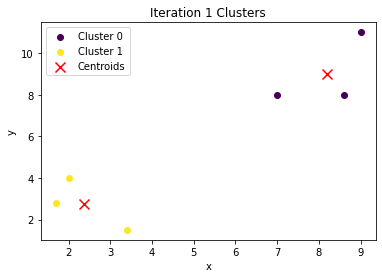

Iteration: 2


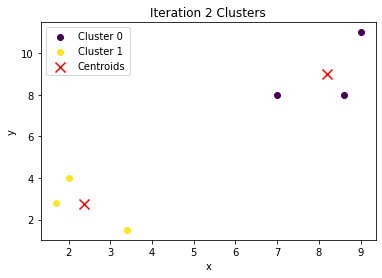

Iteration: 3


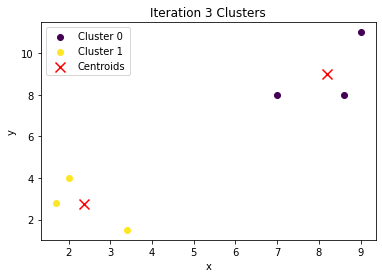

Iteration: 4


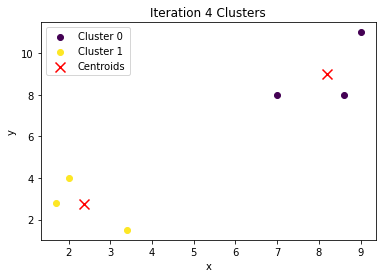

Iteration: 5


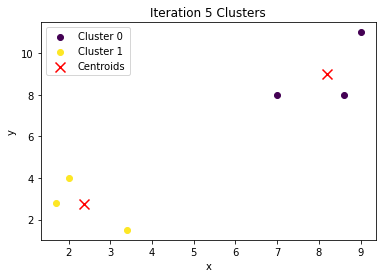

Iteration: 6


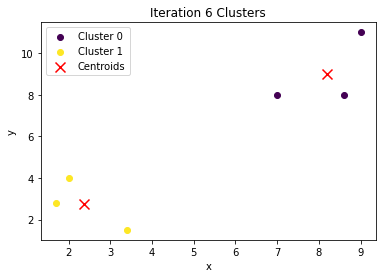

Iteration: 7


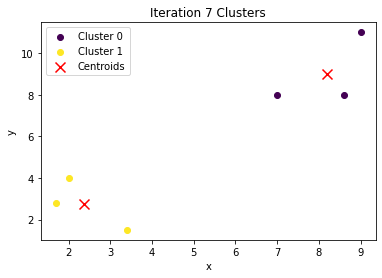

Iteration: 8


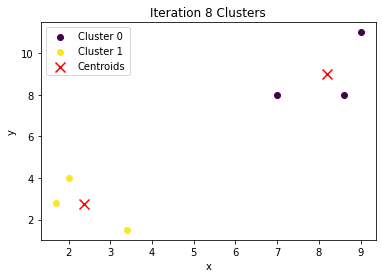

Iteration: 9


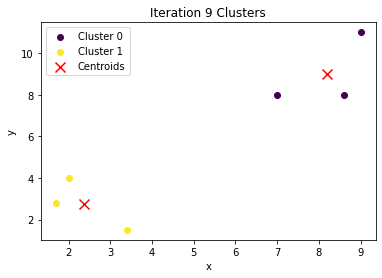

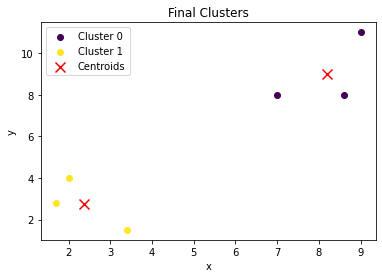

In [16]:
kmeans = KMeansClassifier(x, 2, iterations=10, seed=3)
preds = kmeans.train(viz_it=True, viz_fin=True)

## Test 2

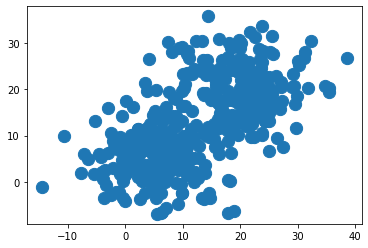

In [17]:
# set the seed
np.random.seed(42) 
# parameters for two normal distributions
mean1, std_dev1 = 5, 6
mean2, std_dev2 = 20, 6
# sample points from two normal distributions
sample_size = 200
dist1 = np.random.normal(mean1, std_dev1, size=(sample_size, 2)) 
dist2 = np.random.normal(mean2, std_dev2, size=(sample_size, 2)) 
# concatenate the points to create a bimodal distribution
x2 = np.vstack((dist1, dist2))
plt.scatter(x2[:,0], x2[:,1], s=150)
plt.show()

2 clusters initiated...
Initializing...


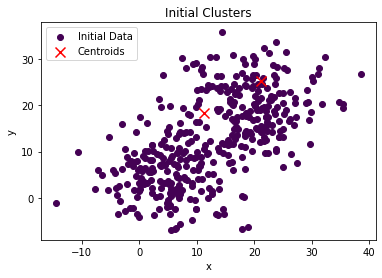

Iteration: 0


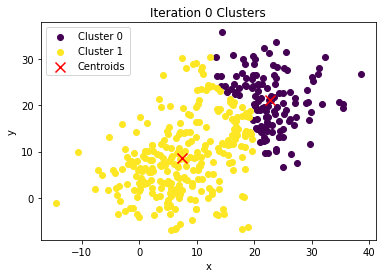

Iteration: 1


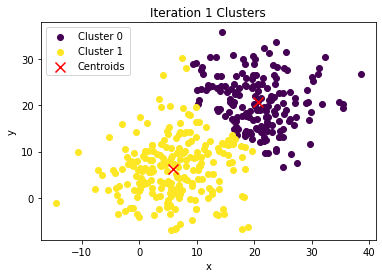

Iteration: 2


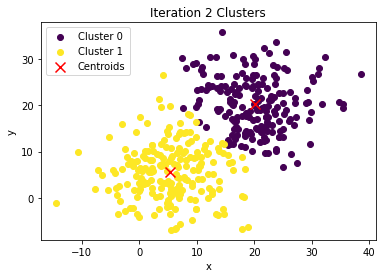

Iteration: 3


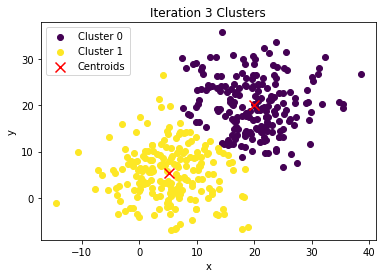

Iteration: 4


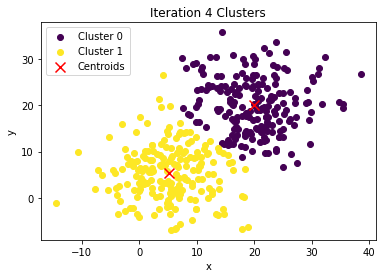

Iteration: 5


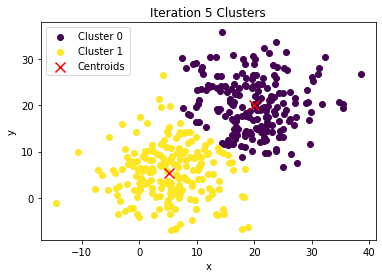

Iteration: 6


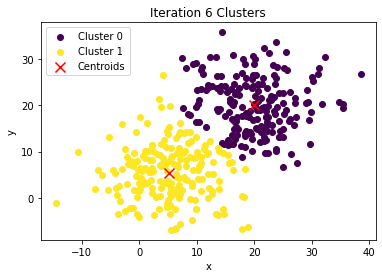

Iteration: 7


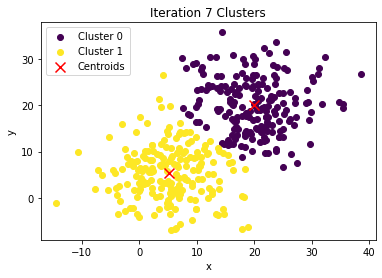

Iteration: 8


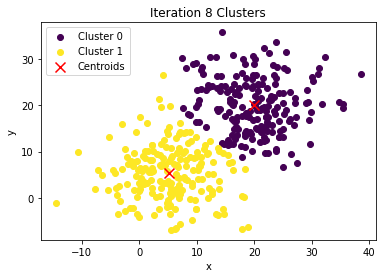

Iteration: 9


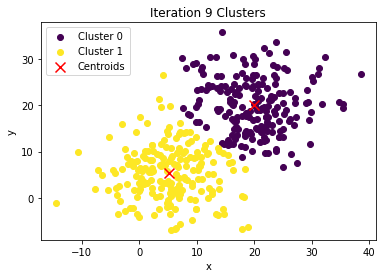

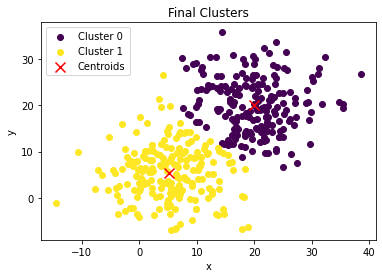

In [18]:
kmeans = KMeansClassifier(x2, 2, iterations=10, seed=3)
preds = kmeans.train(viz_it=True, viz_fin=True)

## Test 3

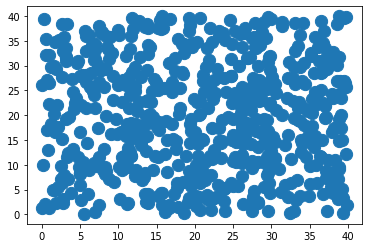

In [19]:
x3 = 40 * (np.random.rand(600, 2))
plt.scatter(x3[:,0], x3[:,1], s=150)
plt.show()

4 clusters initiated...
Initializing...


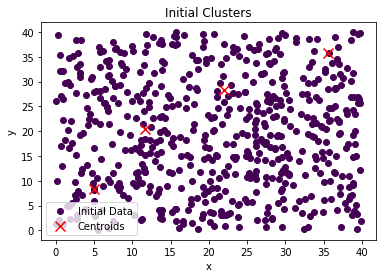

Iteration: 0


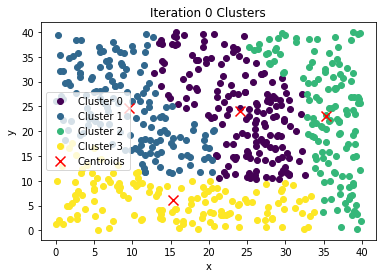

Iteration: 1


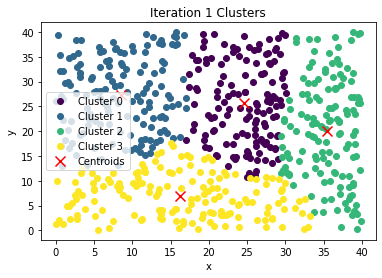

Iteration: 2


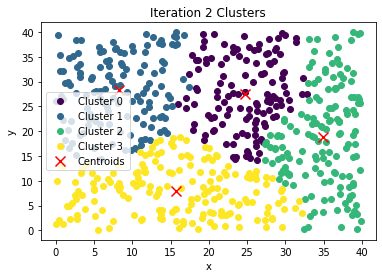

Iteration: 3


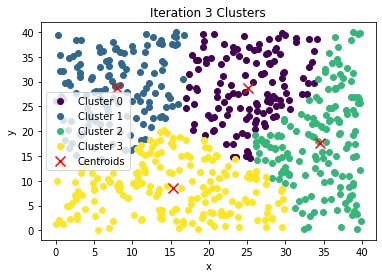

Iteration: 4


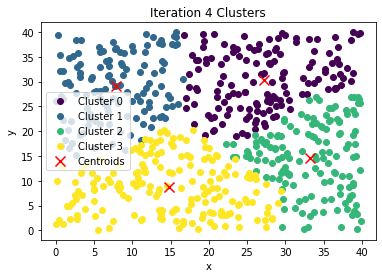

Iteration: 5


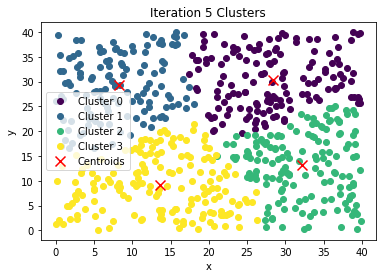

Iteration: 6


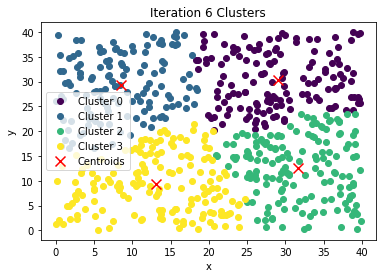

Iteration: 7


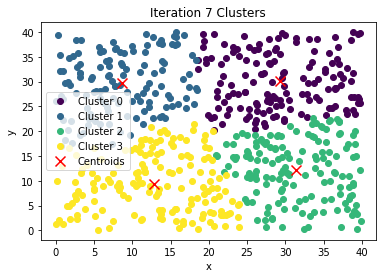

Iteration: 8


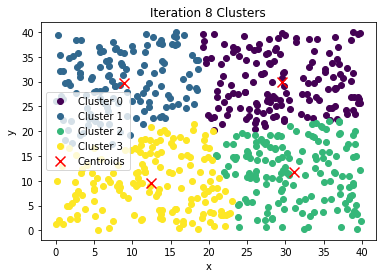

Iteration: 9


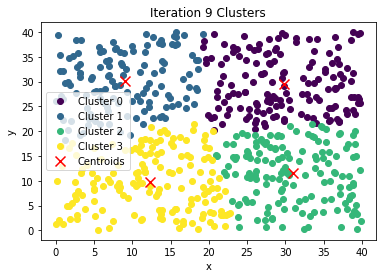

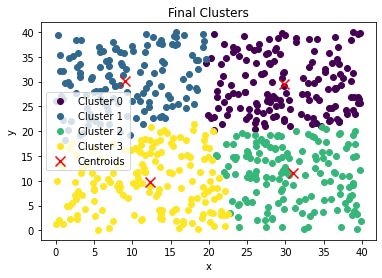

In [20]:
kmeans = KMeansClassifier(x3, 4, iterations=10, seed=3)
preds = kmeans.train(viz_it=True, viz_fin=True)